In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
#applying the segmentation mask on the image
def applying_mask(img,mask):
    masked = np.zeros(img.shape,dtype='uint8')
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if mask[i,j]==1:
                masked[i,j,0] = img[i,j,0]
                masked[i,j,1] = img[i,j,1]
                masked[i,j,2] = img[i,j,2]
    return masked
        

In [3]:
#combining the masks obtained from the three channels
def combining_masks(masks,combine_type):
    maskr = masks[0]
    maskg = masks[1]
    maskb = masks[2]
    
    mask_f = np.zeros(maskr.shape)
    for i in range(mask_f.shape[0]):
        for j in range(mask_f.shape[1]):
            if maskr[i,j]==255.0 and maskg[i,j]==255.0 and maskb[i,j]==255.0 and combine_type == 0 :
                mask_f[i,j] = 1
            if combine_type == 1:
                if (maskr[i,j]==255.0 or maskg[i,j]==255.0 or maskb[i,j]==255.0) :
                    mask_f[i,j] = 1
                
    return mask_f
    
    

In [4]:
#Returns the texture of the image with 3 channels corresponding to 3 window sizes
def get_texture(image,windows):
    img = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    texture = np.zeros((img.shape[0],img.shape[1],3))
   
    for k in range(3):
        w = windows[k]
        for i in range(w,img.shape[0]-w):
            for j in range(w,img.shape[1]-w):
                texture[i,j,k] = np.var(img[i-w:i+w+1,j-w:j+w+1])
                
    texture = texture.astype('uint8')                
               
    return texture

In [5]:
#Implementation of Otsu algorithm
def Otsu(image,channel,parameter,inv):
    
    img = image[:,:,channel]
    mask = 255 * np.ones(img.shape, 'uint8')
    
    for k in range (parameter[channel]):
        histogram, bin_edge = np.histogram(img[np.nonzero(mask)],np.arange(256))
    
        Ds = []
    
        for i in range(len(histogram)):
            h0,h1 = np.split(histogram,[i])
            w0 = np.sum(h0)/np.sum(histogram)
            w1 = np.sum(h1)/np.sum(histogram)
        
            mean0 = np.sum([a*b for a,b in enumerate(h0)])/w0
            mean1 = np.sum([a*b for a,b in enumerate(h1)])/w1
        
            var0 = np.sum([((a-mean0)**2)*b for a,b in enumerate(h0)])/w0
            var1 = np.sum([((a-mean1)**2)*b for a,b in enumerate(h1)])/w1
        
            between = w0*w1*(mean1-mean0)**2
            within = w0*var0 + w1*var1
        
            D = between/1
            D = np.nan_to_num(D)
            Ds.append(D)
        
        Dsn = np.array(Ds)
        threshold = Dsn.argmax()
        if (inv==0):
            _,mask = cv2.threshold(img,threshold,255,cv2.THRESH_BINARY_INV)
            
        if (inv==1):
            _,mask = cv2.threshold(img,threshold,255,cv2.THRESH_BINARY)
    
    return mask
        
        
        

In [6]:
#Wrapper function for Otsu
def combine_Otsu(img,parameter,inv):
    mask_final = np.ones((img.shape[0],img.shape[1]))
    masks = []
    for i in range(3):
        maski = Otsu(img,i,parameter,inv)
        masks.append(maski)
            
   
    return masks
        

In [7]:
#Uses the mask to generate the contour
def get_contour(mask):
    contour = np.zeros(mask.shape)
    for i in range(1,mask.shape[0]-1):
        for j in range(1,mask.shape[1]-1):
            if mask[i,j] == 0:
                continue
            if np.min(mask[i-1:i+2,j-1:j+2])==0:
                contour[i,j] = 1.0
                
                  
    return contour.astype('uint8')

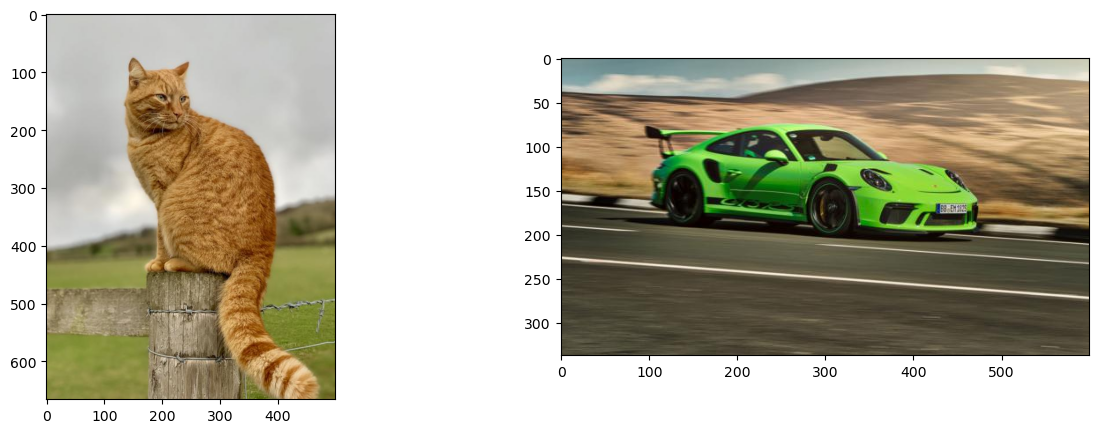

In [8]:
#Displaying all the images
image1 = cv2.imread("cat.jpg")
image1 = cv2.cvtColor(image1,cv2.COLOR_BGR2RGB)

image2 = cv2.imread("car.jpg")
image2 = cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(image1)
ax2.imshow(image2)

#Defining the number of iterations for 1st Otsu method for each of the RGB channels
image1_channel = [0,1,4]
image2_channel = [8,8,1]

C:\Users\adisi\AppData\Local\Temp\ipykernel_3020\3543035357.py:16: RuntimeWarning: invalid value encountered in double_scalars
  mean0 = np.sum([a*b for a,b in enumerate(h0)])/w0
C:\Users\adisi\AppData\Local\Temp\ipykernel_3020\3543035357.py:19: RuntimeWarning: invalid value encountered in double_scalars
  var0 = np.sum([((a-mean0)**2)*b for a,b in enumerate(h0)])/w0
C:\Users\adisi\AppData\Local\Temp\ipykernel_3020\3543035357.py:17: RuntimeWarning: invalid value encountered in double_scalars
  mean1 = np.sum([a*b for a,b in enumerate(h1)])/w1


True

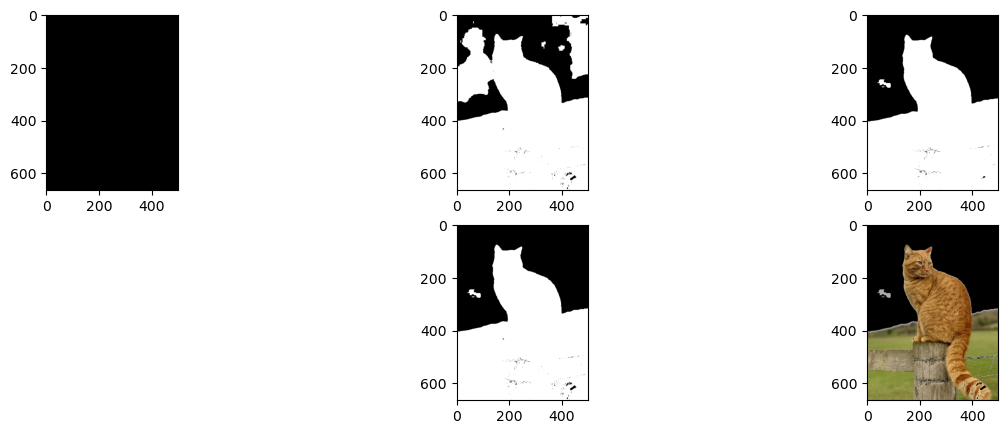

In [9]:
#For image 1, using the 1st Otsu method
mask_ind_1 = combine_Otsu(image1,image1_channel,0)

mask_1 = combining_masks(mask_ind_1,0) #Using and operator to combine the masks

iou1 = applying_mask(image1,mask_1)

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(235)
ax5 = fig.add_subplot(236)

ax1.imshow(mask_ind_1[0],cmap='gray')
ax2.imshow(mask_ind_1[1],cmap='gray')
ax3.imshow(mask_ind_1[2],cmap='gray')
ax4.imshow(mask_1,cmap='gray')
ax5.imshow(iou1,cmap='gray')

cv2.imwrite("mask11.jpg",mask_ind_1[0])
cv2.imwrite("mask12.jpg",mask_ind_1[1])
cv2.imwrite("mask13.jpg",mask_ind_1[2])
cv2.imwrite("mask14.jpg",mask_1*255.0)

iou1 = cv2.cvtColor(iou1, cv2.COLOR_RGB2BGR)
cv2.imwrite("mask15.jpg",iou1)




C:\Users\adisi\AppData\Local\Temp\ipykernel_3020\3543035357.py:16: RuntimeWarning: invalid value encountered in double_scalars
  mean0 = np.sum([a*b for a,b in enumerate(h0)])/w0
C:\Users\adisi\AppData\Local\Temp\ipykernel_3020\3543035357.py:19: RuntimeWarning: invalid value encountered in double_scalars
  var0 = np.sum([((a-mean0)**2)*b for a,b in enumerate(h0)])/w0
C:\Users\adisi\AppData\Local\Temp\ipykernel_3020\3543035357.py:17: RuntimeWarning: invalid value encountered in double_scalars
  mean1 = np.sum([a*b for a,b in enumerate(h1)])/w1


True

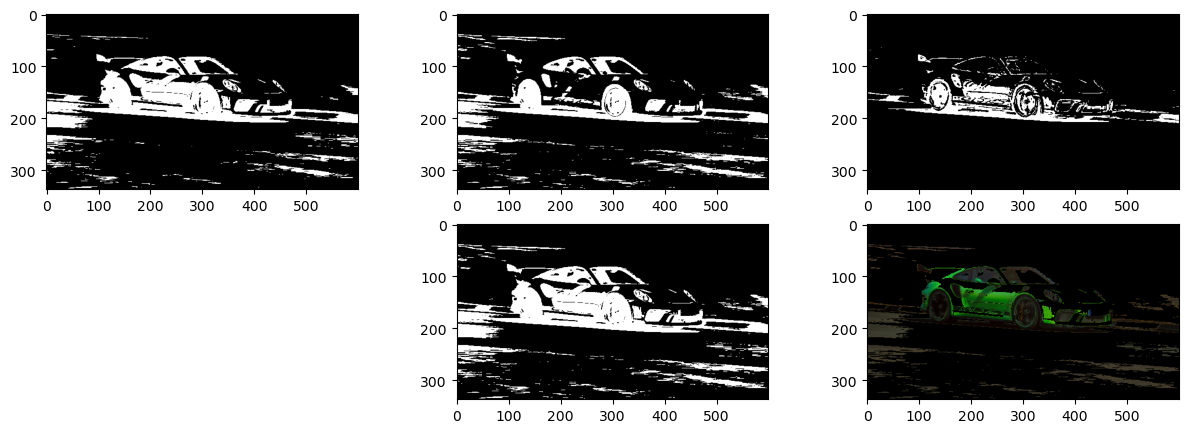

In [10]:
#For image 2, using the 1st Otsu method
mask_ind_2 = combine_Otsu(image2,image2_channel,0)
mask_2 = combining_masks(mask_ind_2,1) #Using or operator to combine the masks

iou2 = applying_mask(image2,mask_2)

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(235)
ax5 = fig.add_subplot(236)

ax1.imshow(mask_ind_2[0],cmap='gray')
ax2.imshow(mask_ind_2[1],cmap='gray')
ax3.imshow(mask_ind_2[2],cmap='gray')
ax4.imshow(mask_2,cmap='gray')
ax5.imshow(iou2,cmap='gray')

cv2.imwrite("mask21.jpg",mask_ind_2[0])
cv2.imwrite("mask22.jpg",mask_ind_2[1])
cv2.imwrite("mask23.jpg",mask_ind_2[2])
cv2.imwrite("mask24.jpg",mask_2*255.0)

iou2 = cv2.cvtColor(iou2, cv2.COLOR_RGB2BGR)
cv2.imwrite("mask25.jpg",iou2)



C:\Users\adisi\AppData\Local\Temp\ipykernel_3020\3543035357.py:16: RuntimeWarning: invalid value encountered in double_scalars
  mean0 = np.sum([a*b for a,b in enumerate(h0)])/w0
C:\Users\adisi\AppData\Local\Temp\ipykernel_3020\3543035357.py:19: RuntimeWarning: invalid value encountered in double_scalars
  var0 = np.sum([((a-mean0)**2)*b for a,b in enumerate(h0)])/w0


True

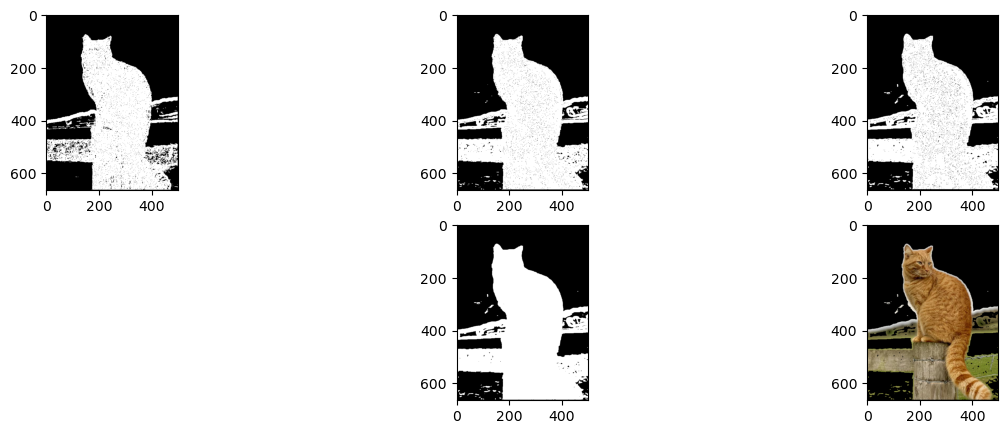

In [11]:
#For image 1 using the 2nd Otsu method
nimage1_channel = [1,1,1]

textures1 = get_texture(image1, [1,2,3])

inmask_ind_1 = combine_Otsu(textures1,nimage1_channel,1)

inmask_1 = combining_masks(inmask_ind_1,1) #Using or operator to combine the masks
niou1 = applying_mask(image1,inmask_1)

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(235)
ax5 = fig.add_subplot(236)

ax1.imshow(inmask_ind_1[0],cmap='gray')
ax2.imshow(inmask_ind_1[1],cmap='gray')
ax3.imshow(inmask_ind_1[2],cmap='gray')
ax4.imshow(inmask_1,cmap='gray')
ax5.imshow(niou1,cmap='gray')

cv2.imwrite("nmask11.jpg",inmask_ind_1[0])
cv2.imwrite("nmask12.jpg",inmask_ind_1[1])
cv2.imwrite("nmask13.jpg",inmask_ind_1[2])
cv2.imwrite("nmask14.jpg",inmask_1*255.0)

niou1 = cv2.cvtColor(niou1, cv2.COLOR_RGB2BGR)
cv2.imwrite("nmask15.jpg",niou1)




C:\Users\adisi\AppData\Local\Temp\ipykernel_3020\3543035357.py:16: RuntimeWarning: invalid value encountered in double_scalars
  mean0 = np.sum([a*b for a,b in enumerate(h0)])/w0
C:\Users\adisi\AppData\Local\Temp\ipykernel_3020\3543035357.py:19: RuntimeWarning: invalid value encountered in double_scalars
  var0 = np.sum([((a-mean0)**2)*b for a,b in enumerate(h0)])/w0


True

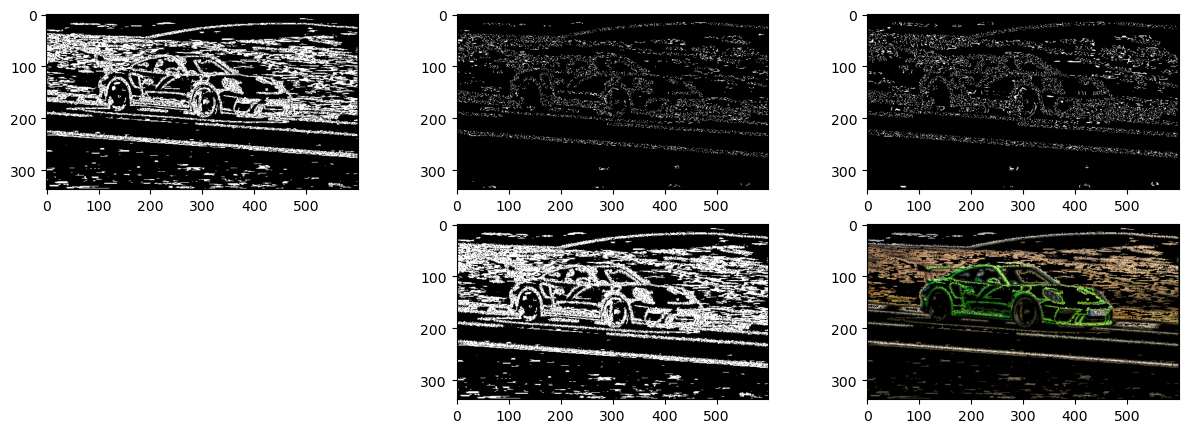

In [12]:
#For image 2 using the 2nd Otsu method
nimage2_channel = [2,2,2]
textures2 = get_texture(image2,[1,2,3])

inmask_ind_2 = combine_Otsu(textures2,nimage2_channel,1)

inmask_2 = combining_masks(inmask_ind_2,1) #Using and operator to combine the masks
niou2 = applying_mask(image2,inmask_2)

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(235)
ax5 = fig.add_subplot(236)

ax1.imshow(inmask_ind_2[0],cmap='gray')
ax2.imshow(inmask_ind_2[1],cmap='gray')
ax3.imshow(inmask_ind_2[2],cmap='gray')
ax4.imshow(inmask_2,cmap='gray')
ax5.imshow(niou2,cmap='gray')

cv2.imwrite("nmask21.jpg",inmask_ind_2[0])
cv2.imwrite("nmask22.jpg",inmask_ind_2[1])
cv2.imwrite("nmask23.jpg",inmask_ind_2[2])
cv2.imwrite("nmask24.jpg",inmask_2*255.0)

niou2 = cv2.cvtColor(niou2, cv2.COLOR_RGB2BGR)
cv2.imwrite("nmask25.jpg",niou2)



True

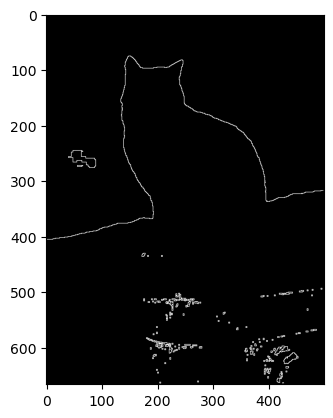

In [13]:
#Producing contours for the 1st image
c11 = get_contour(mask_1)
plt.imshow(c11,cmap='gray')
cv2.imwrite("contour11.jpg",c11*255.0)

True

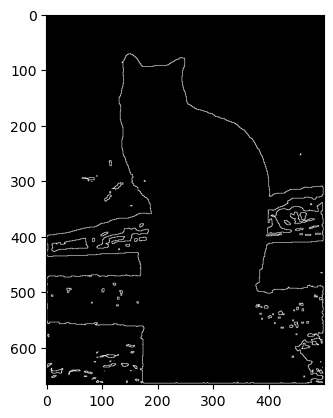

In [14]:
#Producing contours for the 1st image using texture
c12 = get_contour(inmask_1)

plt.imshow(c12,cmap='gray')
cv2.imwrite("contour12.jpg",c12*255.0)

True

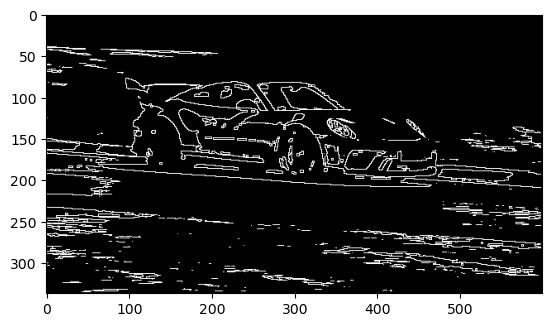

In [15]:
#Producing contours for the 2nd image
c21 = get_contour(mask_2)
plt.imshow(c21,cmap='gray')
cv2.imwrite("contour21.jpg",c21*255.0)

True

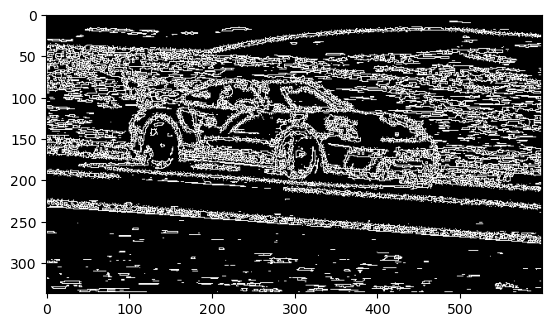

In [16]:
#Producing contours for the 2nd image using texture
c22 = get_contour(inmask_2)
plt.imshow(c22,cmap='gray')
cv2.imwrite("contour22.jpg",c22*255.0)